In [11]:
import cv2
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn import model_selection
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [49]:
# global variables

INPUT_SHAPE_X = 256
INPUT_SHAPE_Y = 256
ITERATION = '1'
EPOCHS = 1000
BATCH_SIZE = 32

max_images = 600 # max images per class

In [13]:
# load labels
csv_path = 'data-labels/labels_preprocessed.csv'
labels = pd.read_csv(csv_path)
# replace NaN values with 0s
labels.fillna(0, inplace=True)

In [50]:
# load the images
head_path = 'data-pain'
head_dir = os.listdir(head_path)
x_head = []
y_head = []
i = 0
class_0 = 0
class_1 = 0
class_2 = 0

# iterate over images
for image in head_dir:
    # load the image
    image_path = os.path.join(head_path, image)
    try:
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
        img = tf.keras.preprocessing.image.img_to_array(img)
        
        # preprocess the image
        if (img is not None):
        
            # check image class
            image_class = labels.loc[labels['imageid'] == image, 'overall_impression']

            if not image_class.empty:
                image_class = image_class.iloc[0]    
                
                # append an equal number of images from each class
                if (image_class == 0.0 and class_0 < max_images):
                    x_head.append(img)
                    y_head.append(image_class)
                    class_0 += 1
                    if (i == max_images*3):
                        break
                    i+=1
                    
                    
                elif (image_class == 1.0 and class_1 < max_images):
                    x_head.append(img)
                    y_head.append(image_class)
                    class_1 += 1
                    if (i == max_images*3):
                        break
                    i+=1
                    
                    
                elif (image_class == 2.0 and class_2 < max_images):
                    x_head.append(img)
                    y_head.append(image_class)
                    class_2 += 1
                    if (i == max_images*3):
                        break
                    i+=1
    except:
        print("issue with", image_path)


issue with data-pain/8e8711a9-46da-4426-88cf-5e45195fa301.png
issue with data-pain/9b26679f-1ae6-49ba-8e30-5814d1b76cab.png
issue with data-pain/a70f45f6-cc25-47e4-a1f9-45b8ba808b0b.jpeg
issue with data-pain/sadcat199.jpg
issue with data-pain/878d1bd2-d695-4a0e-be9b-68a3023c0770.png
issue with data-pain/6dc9d34c-7c03-44cf-a369-3f6721bc56c1.jpg
issue with data-pain/8f369f7d-d78c-4e63-bb2e-973e01445e4c.png
issue with data-pain/b1655a56-58d0-4719-9882-49493b371531.jpeg
issue with data-pain/545f2b7a-ed0a-48de-a0fb-a8daf897b857.png
issue with data-pain/1f04e6ce-d7a0-44f7-9409-08f90f9b781e.png
issue with data-pain/df227fcd-408e-4b78-b04c-8301f4058ac5.jpeg
issue with data-pain/9d7a588e-cbcc-4f22-beb7-80e3a08a9eaa.jpeg
issue with data-pain/7f38ca2e-3fb1-4367-a9ae-b1fb6870ce49.jpeg
issue with data-pain/224653ec-8ac8-402d-b198-44d44b16a440.jpeg
issue with data-pain/42c15231-df17-4b29-a235-8f3f565b98c4.png
issue with data-pain/033ddaa7-f64f-4402-841a-f43c45c2352a.jpeg
issue with data-pain/ac3b9af

In [51]:
# add flipped images from class 2
flipped_path = 'data/full-flipped'
for image in os.listdir(flipped_path):
    image_path = os.path.join(flipped_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    x_head.append(img)
    y_head.append(2)
    class_2 += 1

In [52]:
# add augmented images from class 2
aug_path = 'data/full-augmented'
for image in os.listdir(aug_path):
    image_path = os.path.join(aug_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    x_head.append(img)
    y_head.append(2)
    class_2 += 1

In [19]:
print(class_0, class_1, class_2)

600 600 600


In [53]:
# preprocess
x_head = tf.keras.applications.resnet50.preprocess_input(np.array(x_head))

# split the dataset into train and test sets
x_train_val, x_test, y_train_val, y_test = model_selection.train_test_split(
    x_head, y_head, test_size=0.2, random_state=42)

# split the train and validation sets
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    x_train_val, y_train_val, test_size=0.2, random_state=42)

# one-hot code labels
y_train = tf.cast(y_train,dtype=tf.int32)
y_val = tf.cast(y_val,dtype=tf.int32)
y_test = tf.cast(y_test,dtype=tf.int32)

y_train = tf.one_hot(y_train,3)
y_val = tf.one_hot(y_val,3)
y_test = tf.one_hot(y_test,3)

In [69]:
# create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.applications.resnet50.ResNet50(weights='weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                                            include_top=False,
                                            input_shape=(INPUT_SHAPE_X, INPUT_SHAPE_Y, 3)))
model.add(tf.keras.layers.Flatten(input_shape=model.output_shape[1:]))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [70]:
# compile the model
earlystop = EarlyStopping(monitor='val_loss', patience=10)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [76]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 131072)            0         
                                                                 
 dense_20 (Dense)            (None, 256)               33554688  
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 256)               65792     
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 128)              

In [71]:
# train the model
hist = model.fit(x_train, y_train, 
              epochs=EPOCHS,
              batch_size=BATCH_SIZE, 
              validation_data=(x_val, y_val),
              callbacks=[earlystop])

Epoch 1/1000


2023-04-27 15:22:54.194686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 1.3594 - accuracy: 0.3945

2023-04-27 15:23:48.555410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 61s 2s/step - loss: 1.3594 - accuracy: 0.3945 - val_loss: 1.1585 - val_accuracy: 0.3984
Epoch 2/1000
32/32 [==============================] - 53s 2s/step - loss: 0.8675 - accuracy: 0.6045 - val_loss: 1.1478 - val_accuracy: 0.4062
Epoch 3/1000
32/32 [==============================] - 54s 2s/step - loss: 0.6432 - accuracy: 0.7383 - val_loss: 1.1712 - val_accuracy: 0.4062
Epoch 4/1000
32/32 [==============================] - 55s 2s/step - loss: 0.4766 - accuracy: 0.8037 - val_loss: 1.1498 - val_accuracy: 0.4453
Epoch 5/1000
32/32 [==============================] - 53s 2s/step - loss: 0.3497 - accuracy: 0.8721 - val_loss: 1.2495 - val_accuracy: 0.4531
Epoch 6/1000
32/32 [==============================] - 54s 2s/step - loss: 0.2686 - accuracy: 0.9111 - val_loss: 1.2289 - val_accuracy: 0.4570
Epoch 7/1000
32/32 [==============================] - 56s 2s/step - loss: 0.1820 - accuracy: 0.9561 - val_loss: 1.1744 - val_accuracy: 0.5117
Epoch 8/1000
32/32 

In [55]:
# save the model and training history
path = 'model-full'
model.save(path)

history_df = pd.DataFrame(hist.history)
path = 'history-full.csv'
history_df.to_csv(path, index=False)

INFO:tensorflow:Assets written to: model-eyes/assets


INFO:tensorflow:Assets written to: model-eyes/assets


In [72]:
# evaluate the model
results = model.evaluate(x_test, y_test)
print(results)

10/10 [==============================] - 5s 483ms/step - loss: 1.2245 - accuracy: 0.5281
[1.2245447635650635, 0.528124988079071]


In [73]:
# make predictions
prob_array = model.predict(x_test)
class_indices = np.argmax(prob_array, axis=1)

# convert the class indices to a one-hot encoded array
class_indices = np.argmax(prob_array, axis=1)
num_classes = 3
y_pred = np.zeros((prob_array.shape[0], num_classes))
y_pred[np.arange(prob_array.shape[0]), class_indices] = 1

2023-04-27 15:55:36.024066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 7s 473ms/step


In [74]:
# make a classification report

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Score 0', 'Score 1', 'Score 2']))


Accuracy: 0.53


Classification Report

              precision    recall  f1-score   support

     Score 0       0.61      0.57      0.59       130
     Score 1       0.45      0.61      0.52       119
     Score 2       0.59      0.32      0.42        71

   micro avg       0.53      0.53      0.53       320
   macro avg       0.55      0.50      0.51       320
weighted avg       0.55      0.53      0.52       320
 samples avg       0.53      0.53      0.53       320



Confusion Matrix

[[74 52  4]
 [35 72 12]
 [12 36 23]]


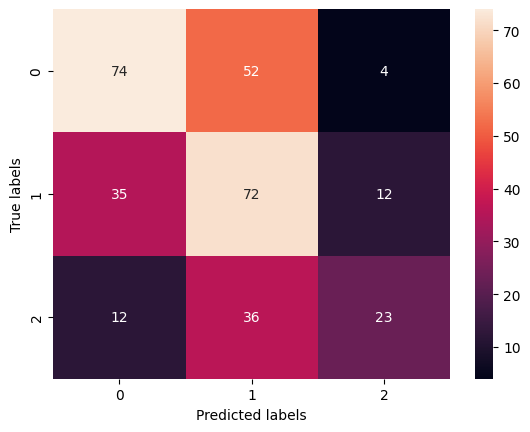

In [75]:
# make a confusion matrix
confusion = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
print('Confusion Matrix\n')
print(confusion)

lables = ['0','1','2']    
ax= plt.subplot()
sns.heatmap(confusion, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(lables); ax.yaxis.set_ticklabels(lables);
plt.show()